In [143]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandrakozevnikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
!kaggle competitions download -c hse-nlp-bootcamp

Traceback (most recent call last):
  File "/Users/aleksandrakozevnikova/opt/anaconda3/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/aleksandrakozevnikova/.kaggle. Or use the environment method.


In [145]:
df = pd.read_csv('train_ml.csv')
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1.0,16.02.2017 16:10
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2.0,13.12.2016 1:05
2,alfabank,Здравствуйте!Ранее уже оставлял отзыв о вашем ...,NaN,28.06.2019 13:54
3,vtb,Обращаюсь к Вам с жалобой на незаконное списан...,NaN,15.07.2020 14:54
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2.0,04.08.2020 6:38
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1.0,26.10.2016 11:03
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2.0,01.02.2020 21:07
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1.0,14.06.2016 16:03
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3.0,21.04.2020 8:24


# Some EDA

Сразу видим, что в столбце с целевой переменной (`grades`) есть пропуски. В этом ноутбуке будем обучаться на отзывах, для которых есть информация о значении таргета. **Но это не единственный подход. Подумайте, что ещё можно сделать**

Посмотрим, есть ли пропуски в признаках

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bank    75000 non-null  object 
 1   feeds   75000 non-null  object 
 2   grades  51476 non-null  float64
 3   date    75000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


Сразу преобразуем столбец с меткой времени к соответствующему формату. И удалим строчки с пропусками в таргете

In [146]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df = df.dropna()
#df = df.fillna(method = 'pad')
df = df.astype({'grades': 'int32'})
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,2017-02-16 16:10:00
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,2016-12-13 01:05:00
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,2020-08-04 06:38:00
7,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015-04-19 20:11:00
8,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,2019-03-28 18:36:00
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1,2016-10-26 11:03:00
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,2020-02-01 21:07:00
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,2016-06-14 16:03:00
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,2020-04-21 08:24:00


Посмотрим на распределение числа отзывов по банкам

In [7]:
feeds_by_bank_count = df.bank.value_counts()
feeds_by_bank_count

sberbank          12898
vtb                7457
tcs                6425
fk_otkritie        3651
homecreditbank     3408
                  ...  
intesa               43
bystrobank           42
primsotsbank         39
rncb                 37
rnbank               36
Name: bank, Length: 69, dtype: int64

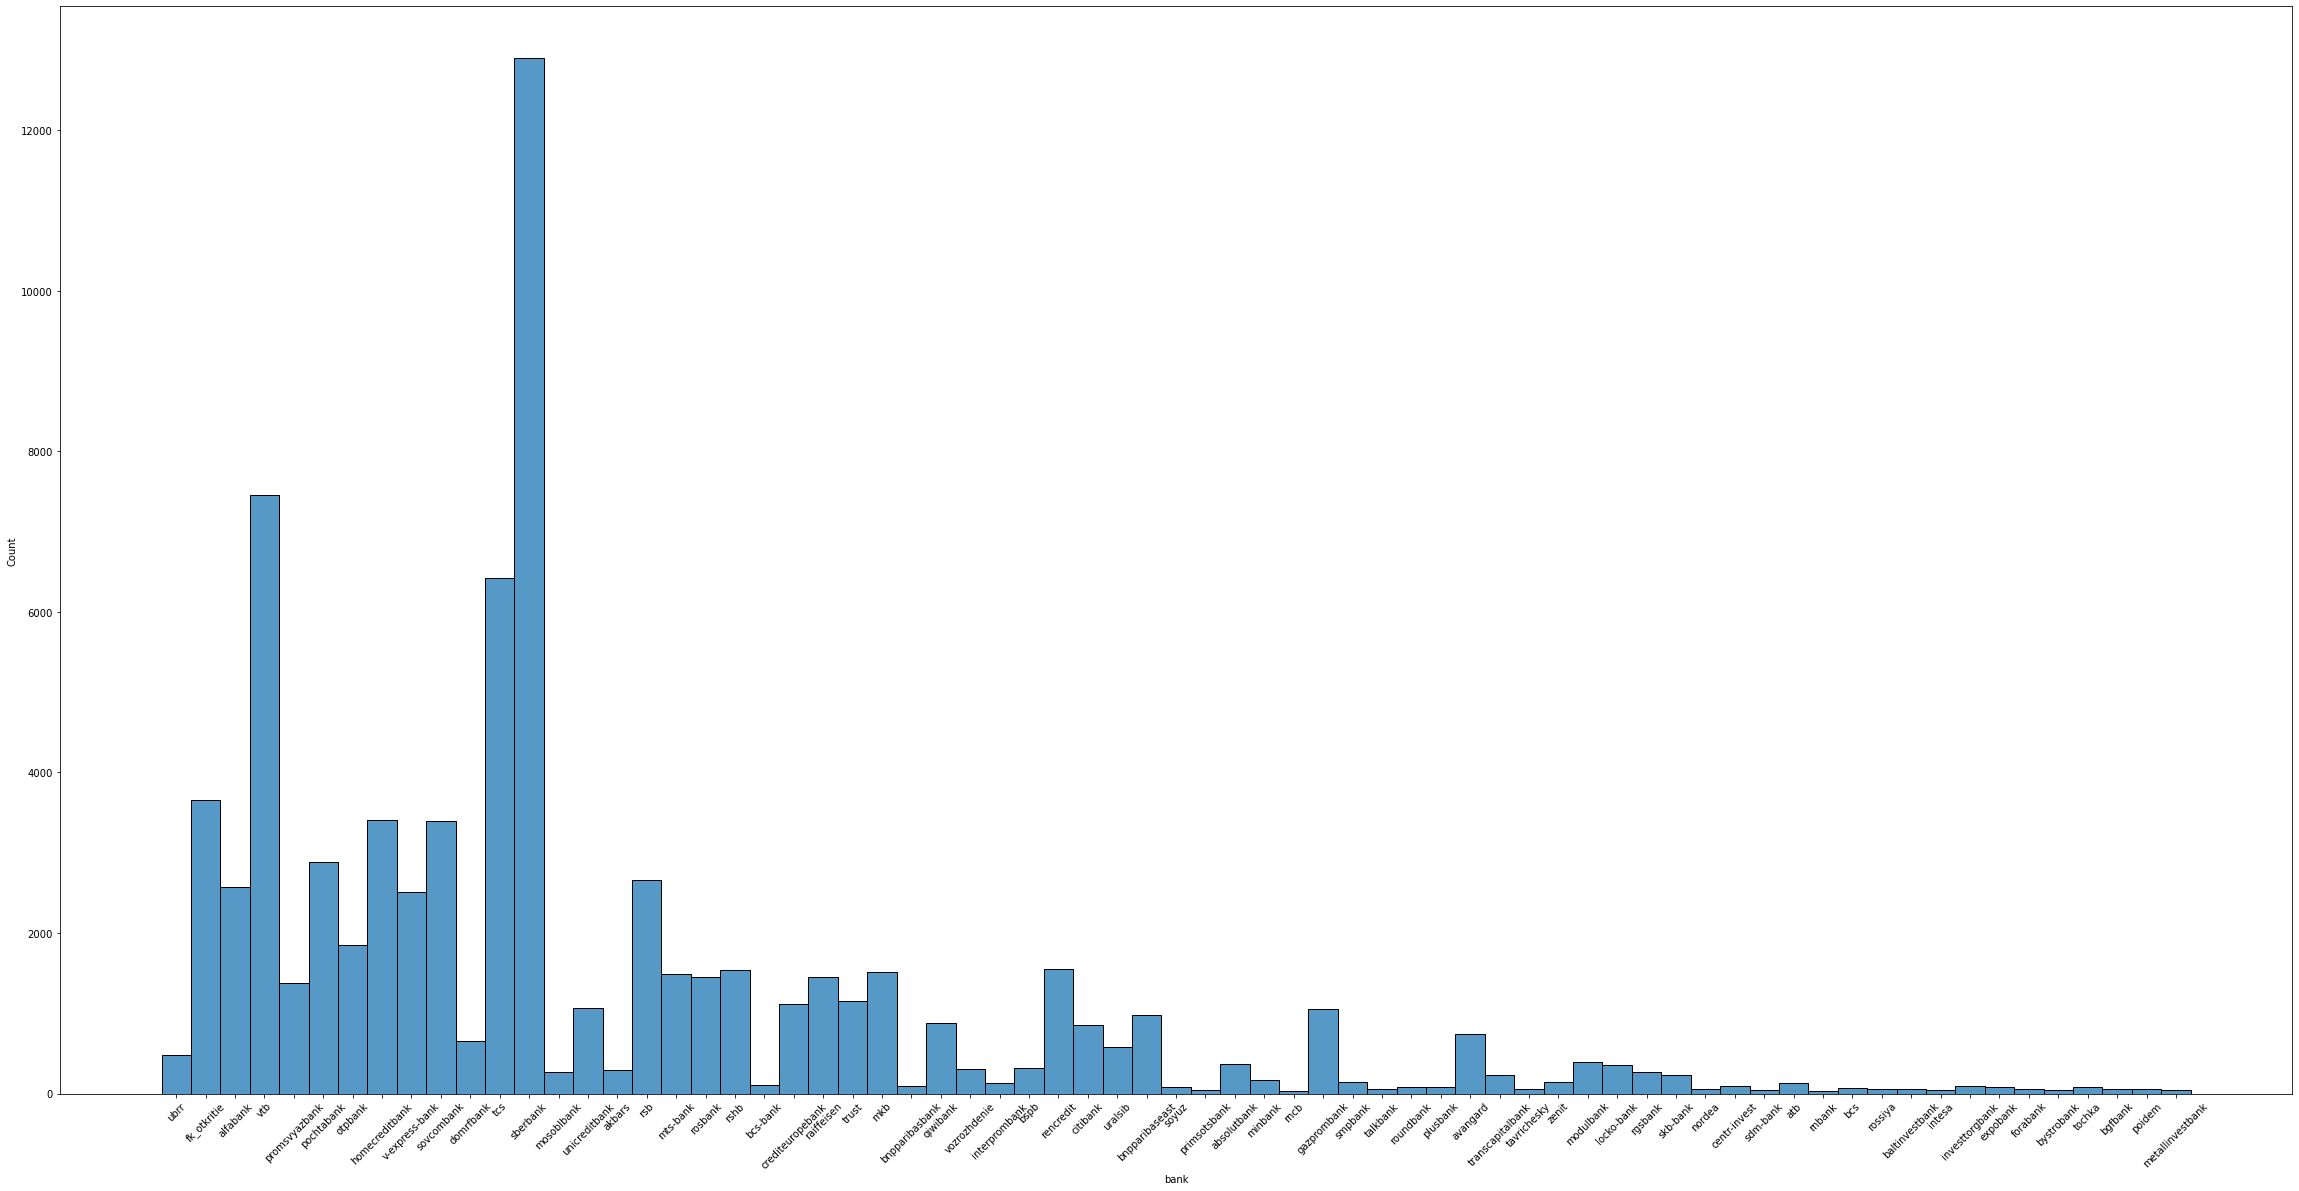

In [8]:
plt.figure(figsize=(40,20))
sns.histplot(data=df.sort_values(by='bank'), 
             x=df.bank, )
plt.xticks(rotation=45)
plt.show()

Глянем на распределение клиентских оценок

In [9]:
df.grades.value_counts().sort_index()

1    40288
2     8288
3     3389
4     2186
5    20849
Name: grades, dtype: int64

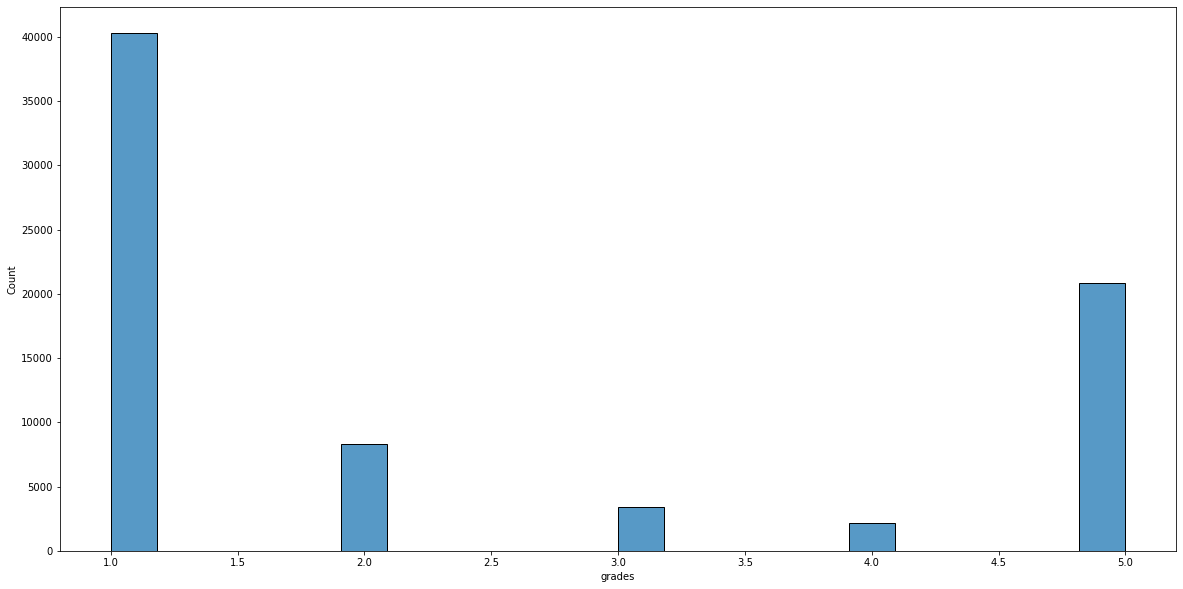

In [10]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df, 
             x=df.grades, )
plt.show()

Также нас интересуют длины отзывов

In [11]:
df['sym_len'] = df.feeds.apply(len)
df['word_len'] = df.feeds.apply(lambda x: len(x.split()))

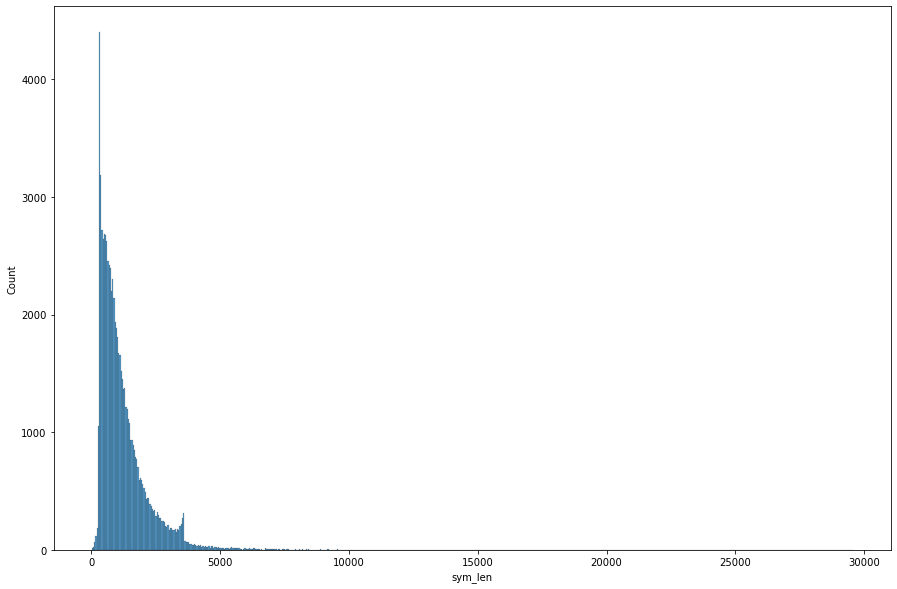

In [12]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.sym_len)
plt.show()

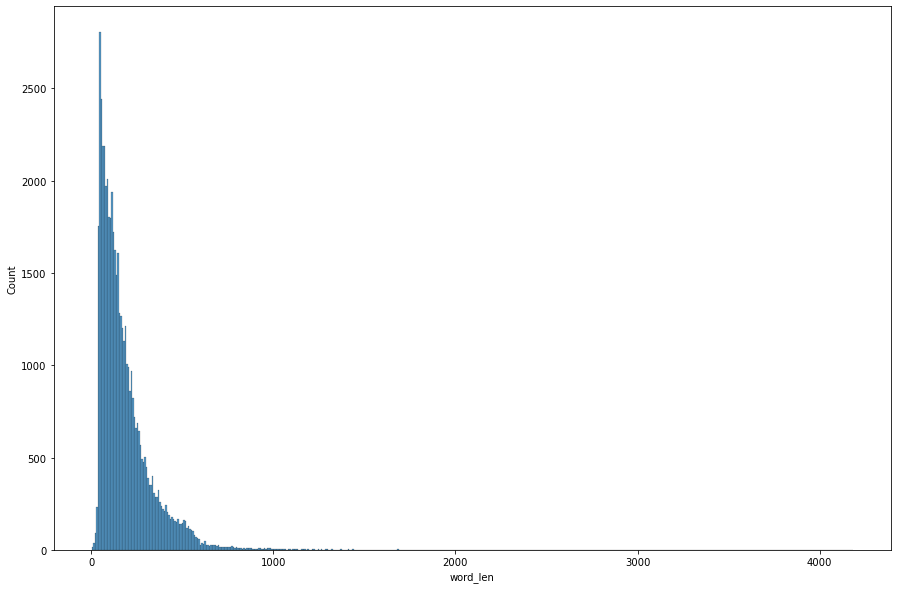

In [16]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.word_len)
plt.show()

Обратите внимание, у распределений очень длинные хвосты

# Baseline (tf-idf + logreg)

Подготавливаем тексты отзывов (взято из ноутбука второго занятия 😃)

In [147]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [148]:
#lemmas = list(map(clean_text, df['feeds']))
    
#df['lemmas'] = lemmas
#df.sample(5)
lemmas = df.feeds.apply(lambda i: clean_text(i))

Будем обучаться исключительно на текстах отзывов (признаки `bank`и `date` не используем от слова совсем -- **мы не используем, а вы в своих решениях попробуйте**)

In [149]:
y_train = df.grades
y_train = y_train.reset_index().drop(columns='index')
del df # высвободим оперативу, она нам не помешает

Обучимся на всех объектах, а потом сделаем предсказание на тесте из соревнования. Ни больше, ни меньше

In [150]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 2), max_features = 4096) # используем уни-, биграммы
bow = vec.fit_transform(lemmas)
clf = LogisticRegression(random_state=42, max_iter=500, warm_start=True)


CPU times: user 17.9 s, sys: 1.78 s, total: 19.6 s
Wall time: 21 s


In [151]:
y_train

,grades
0,1
1,2
2,2
3,5
4,2
...,...
51471,1
51472,2
51473,1
51474,3


In [152]:
# небольшой трюк: будем обучаться частями
ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10) # разобъем на 10 частей
# и подмешаем к каждому куску случайных объектов
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=1000))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    clf.fit(bow[chunk, :], y_train.iloc[chunk])


  0%|          | 0/10 [00:00<?, ?it/s]/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 10%|█         | 1/10 [00:00<00:08,  1.10it/s]/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|██        | 2/10 [00:01<00:06,  1.17it/s]/Users/aleksandrakozevnikova/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

Загрузим тест. Предобработаем отзывы в нем и сделаем предсказания

In [153]:
test = pd.read_csv('new_test_ml.csv', index_col=0)
test

,bank,feeds,date
0,sberbank,Оформляем ипотеку в Сбербанке. 22.06.2020 были...,01.07.2020 10:53
1,alfabank,Краткое содержание: не рекомендую брать кредит...,20.06.2019 13:19
2,v-express-bank,"Добрый день, уважаемые сотрудники службы контр...",20.02.2016 11:46
3,homecreditbank,"Обращался за получением карты ""Зеленая польза""...",06.05.2019 15:48
4,vtb,20.05.2016 обратилась в отделение банка на про...,23.05.2016 15:41
...,...,...,...
17215,sberbank,"21.09.2018 в 15:26:56, я, О-ва К. К., снимала ...",22.09.2018 16:08
17216,homecreditbank,"Наверняка не засчитают, но тем не менее. Нужна...",06.10.2011 9:35
17217,interprombank,"15.08.2019 я, как физ.лицо обратилась в офис н...",21.08.2019 14:13
17218,otpbank,"У банка есть рекламный продукт-игра ""Мои рыбки...",29.05.2020 16:12


In [154]:
#with Pool(4) as p:
    #lemmas_test = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))
#lemmas_test = list(map(clean_text, test['feeds']))
lemmas_test = test.feeds.apply(lambda i: clean_text(i))

In [155]:
pred = clf.predict(vec.transform(lemmas_test))
pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [156]:
sol = pd.DataFrame({'inds': test.index,
                    'grades': pred})
sol

,inds,grades
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
17215,17215,1
17216,17216,1
17217,17217,1
17218,17218,1


In [158]:
sol.to_csv('new_baseline.csv', index=False)

Кстати, если обратите внимание на содержимое вектора предсказанных классов, то наверняка заметите, что модель предсказывает только 1 и 5, редко 2 и 3 и вообще никогда класс 4. Отчасти это логично -- наблюдается сильный дисбаланс классов. Но этот недочет неплохо бы исправить в ваших решениях

In [157]:
unique, counts = np.unique(pred, return_counts=True)
np.asarray((unique, counts)).T

array([[    1, 12400],
       [    2,    65],
       [    5,  4755]])